# Tree sway video analysis for a snow unloading event on Snoqualmie Pass

**Author: Joe Ammatelli, Joseph.Ammatelli@dri.edu, 2025**

**Overview**

This notebook facilitates the extraction and comparison of tree sway frequency data from a sequence of videos.
The notebook was specifically implemmented for evaluating a snow unloading event observed on Snoqualmie Pass in Washington. 

Here, we extract sway frequency data from two videos using an adapted video processing algorithm based on the Virtual Vision Sensor algorithm from Schumacher and Shariati (2013).

The notebook is divided into 5 parts:
1. Initialize processing parameters
2. Extract sway frequencies from video 1 using the 'Virtual Vision Sensor' (VVS) algorithm
3. Extract sway frequencies from video 2 using the 'Virtual Vision Sensor' (VVS) algorithm
4. Compare sway frequencies from video 1 and video 2
5. Publication-quality plot

The workflow has been designed so that users configure essential processing parameters in step 1 and then simply step through the remaining cells.

Part 5 includes code used to generate a publication quality figure.

**Description of Video Processing Pipeline**

The logic for both video processing algorithms has been abstracted into a modular workflow with 4 abstract steps:
1. Translating a video to vibration signals (vid2vib_utils.py)
2. Estimating the power spectral density (PSD) of each vibration signal (spectra_utils.py)
3. Aggregating frequency content across all vibration signals (aggregate_utils.py)
4. Reporting the output peak frequency (plotting_utils.py)

Functions related to each abstract step are implemented in the util python files in parentheses above.

Each video processing algorithm then has an Analyzer object that combines functions from the util files to create an end-to-end algorithm. Each Analyzer object has one function corresponding to each abstract step. These functions serve as wrappers and enable users users to customize key elements of the video processing pipeline without modifying the pipeline itself. For key computation steps, users can invoke existing functions or define their own. For example, for step 2, users can choose from existing methods for estimating the power spectral density (see spectra_utils.py) or define their own.

Once processing parameters have been configured, the user can simiply call each step of the analyer object to process the video.

**Sources**

Schumacher, T., & Shariati, A. (2013). Monitoring of Structures and Mechanical Systems Using 
    Virtual Visual Sensors for Video Analysis: Fundamental Concept and Proof of Feasibility. 
    Sensors, 13(12), Article 12. https://doi.org/10.3390/s131216551

In [6]:
import matplotlib
import matplotlib.pyplot as plt


from swayfreq.analyzers import vvs_lyzer
from swayfreq.utils import vid2vib_utils
from swayfreq.utils import spectra_utils
from swayfreq.utils import plotting_utils

## 1. Initialize processing parameters

### 1.1 Choose video data

In [7]:
# video samples and corresondting time-stamp
# times are in PST
vid_datetimes = {'snoqualmie-a' : '2020-02-23 14:48:10', 
                 'snoqualmie-b' : '2020-02-23 14:50:10',
                 'snoqualmie-c_unloading' : '2020-02-23 14:52:10',
                 'snoqualmie-d' : '2020-02-23 14:54:10',
                 'snoqualmie-e' : '2020-02-23 14:56:10',
                 'snoqualmie-f' : '2020-02-23 14:58:10',
                 'snoqualmie-g' : '2020-02-23 15:00:10'}

# name of videos to process and compare
vid1_name = 'snoqualmie-b'
vid2_name = 'snoqualmie-f'

# path to video sample
vid_path = '../data/snoqualmie/video/{vid_name}.mp4'

### 1.2 Choose region of interest (ROI) or optionally define your own

In [8]:
roi = 'tree1_whole'
rois = {'tree1_whole' : [200, 700, 980, 1180],
        'tree1_branch' : [450, 510, 1050, 1175]}

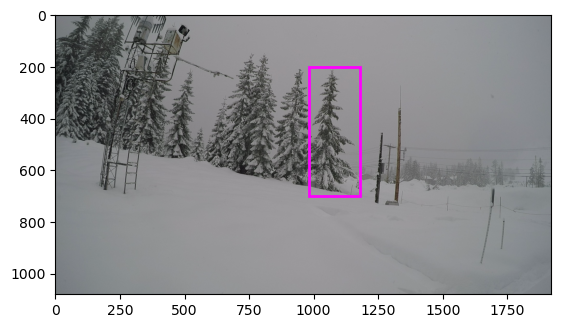

In [9]:
ax = plotting_utils.plot_frame(vid_path.format(vid_name=vid1_name), ticks=True, figsize=None)
plotting_utils.plot_rois(ax, [rois[roi]])

### 1.3 Specify a location to store the processing context, output data, and figures

In [10]:
out_prefix = './data/niwot/output/{vid_name}' + f'_{roi}'

### 1.4 Define video processing parameters

The video processing pipeline, regardless of algorithm type, is divided into 4 main steps:
1. Translating a video to vibration signals
2. Estimating the power spectral density (PSD) of each vibration signal
3. Aggregating frequency content across all vibration signals
4. Reporting the output peak frequency

The parameters for each step are configured below. For a description of functions their arguments see:
* vid2vib_utils.py
* spectra_utils.py
* aggregate_utils.py
* plotting_utils.py
* accelerometer_utils.py

#### 1.4.1 Parameters for video to vibration translation

In [11]:
# keyword arguments for VVS video to vibration translation (which uses vid2vib.uncompressed_vid)
vid2vib_vvs_kwargs = {'reduction':'gray'}

#### 1.4.2 Parameters for estimating the power spectral density (PSD) of each signal

In [12]:
# lower bound of canidate frequencies
freqmin = 0.1

# upper bound of candidate frequencies
freqmax = 0.8

# function used to estimate PSD of vibration signals
spectra_func = spectra_utils.get_spectra_periodogram

# kwargs for spectra_func
spectra_func_kwargs = {'window':'hann', 'nfft':4096}

#### 1.4.3  Parameters for aggregating the frequency content across all vibration spectra

In [13]:
# function used to aggregate vibration PSDs
dom_freq_func = spectra_utils.get_dom_freq_peak_finder

# kwargs for aggregating function
dom_freq_func_kwargs = {}

# masks applied to vibration signals
percentile=75  # percentile of peak prominences below which signals are masked

# mask type
masks = [{'name':f'Prominence, {percentile}th percentile',
          'weight':'prominence',
          'kwargs':{'stat_reduc':'percentile', 'percentile':percentile}}]

#### 1.4.4 Parameters for reporting the output

In [14]:
figsize=(14,7)

## 2. Extract sway frequencies from video 1 using the 'Virtual Vision Sensor' (VVS) algorithm

In [15]:
def get_dom_freq(vid_name, roi):
    in_path = vid_path.format(vid_name=vid_name)
    out_path = out_prefix.format(vid_name=vid_name)
    
    vvs = vvs_lyzer.VVSAnalyzer(in_path, rois[roi], out_path)
    vib_vvs, fps = vvs.vid2vib(vid2vib_vvs_kwargs)
    freq_vvs, pxx_vvs = vvs.compute_spectra(freqmin, freqmax, spectra_func, spectra_func_kwargs) 
    agg_df_vvs, pxx_avg_vvs, pxx_avg_peak_idx_vvs, dom_freq, masked, masked_avg_spectrums, masked_avg_spectrums_peak_idxs = vvs.aggregate(dom_freq_func, dom_freq_func_kwargs, masks=masks)
    return vib_vvs, freq_vvs, dom_freq, masked[0], pxx_avg_vvs

In [16]:
vib1, freqs, dom_freq_v1, dom_freq_masked_v1, pxx_avg_vvs_v1 = get_dom_freq(vid1_name, roi=roi)

Reading video into array
1811
Finished reading video into array
Computing pixel spectra
Finished computing spectra


Text(0.5, 1.0, 'Video 1: snoqualmie-b')

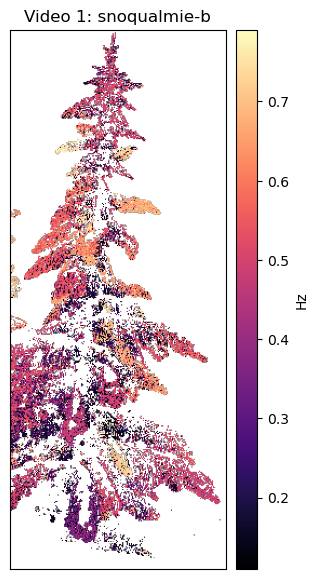

In [17]:
ax = plotting_utils.plot_image(dom_freq_masked_v1, colorbarlabel='Hz', figsize=figsize)
ax.set_title(f'Video 1: {vid1_name}')

## 3. Extract sway frequencies from video 2 using the 'Virtual Vision Sensor' (VVS) algorithm

In [18]:
vib2, freqs, dom_freq_v2, dom_freq_masked_v2, pxx_avg_vvs_v2 = get_dom_freq(vid2_name, roi)

Reading video into array
1811
Finished reading video into array
Computing pixel spectra
Finished computing spectra


Text(0.5, 1.0, 'Video 2: snoqualmie-f')

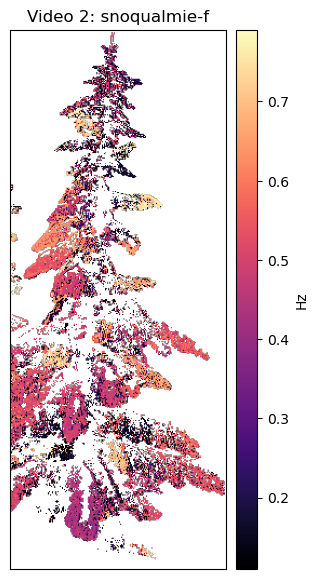

In [19]:
ax = plotting_utils.plot_image(dom_freq_masked_v2, colorbarlabel='Hz', figsize=figsize)
ax.set_title(f'Video 2: {vid2_name}')

## 4. Compare sway frequencies from video 1 and video 2

### 4.1 Pixelwise comparison of frequency

Text(0.5, 1.0, 'Video 2 - Video 1')

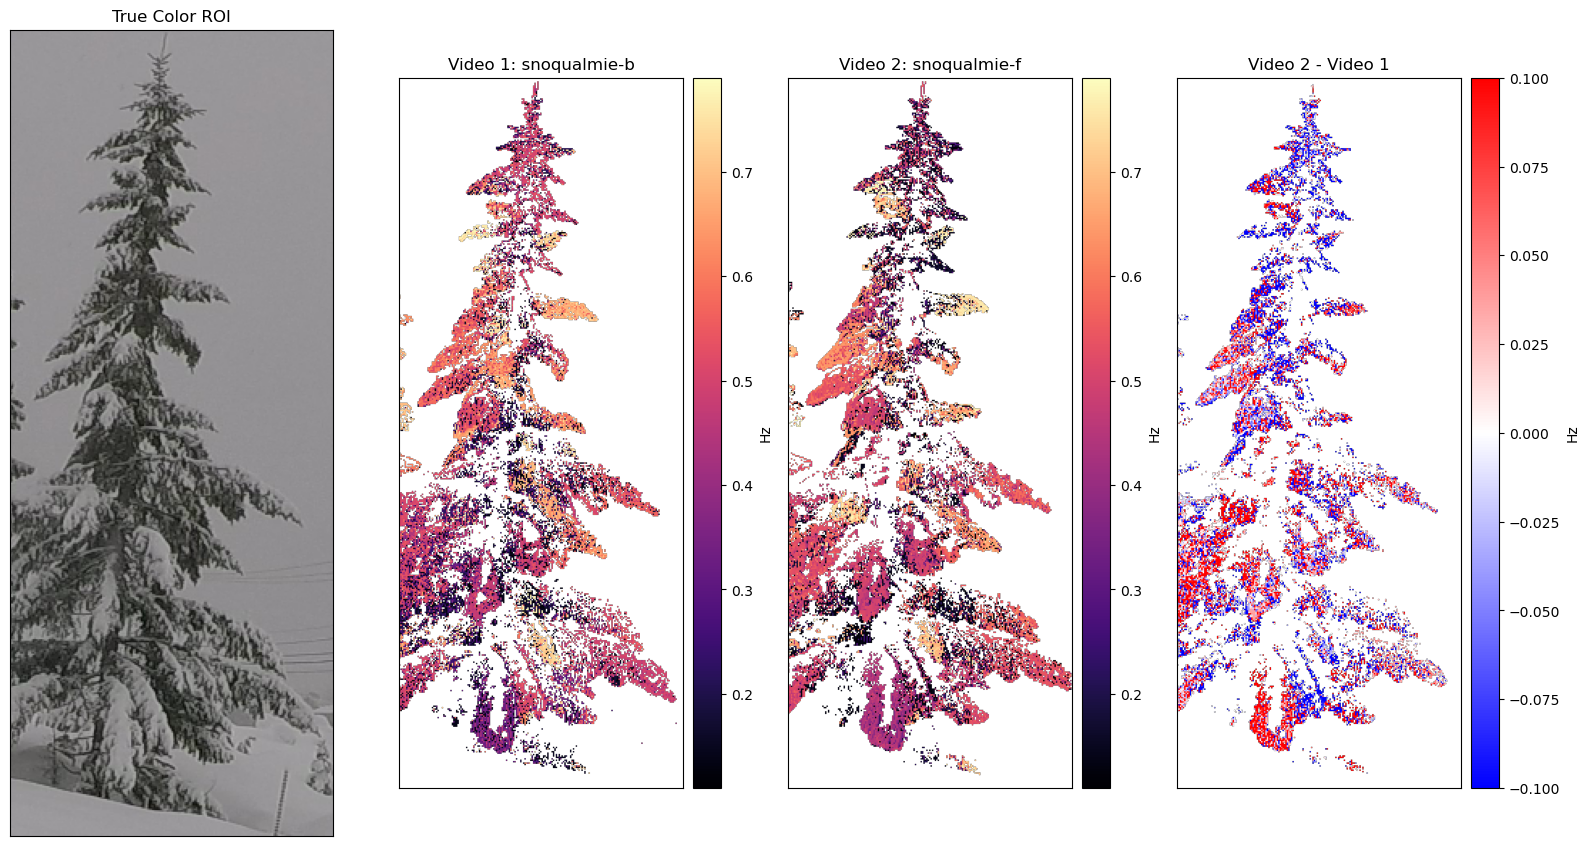

In [20]:
fig, ax = plt.subplots(1,4, figsize=(16,28), tight_layout=True)

frame = vid2vib_utils.get_frame(vid_path.format(vid_name=vid1_name))
ymin, ymax, xmin, xmax = rois[roi]
roi_tc = frame[ymin:ymax, xmin:xmax, :]
plotting_utils.plot_truecolor_image(roi_tc, ax=ax[0])
ax[0].set_title(f'True Color ROI')

plotting_utils.plot_image(dom_freq_masked_v1, colorbarlabel='Hz', figsize=figsize, ax=ax[1])
ax[1].set_title(f'Video 1: {vid1_name}')

plotting_utils.plot_image(dom_freq_masked_v2, colorbarlabel='Hz', figsize=figsize, ax=ax[2])
ax[2].set_title(f'Video 2: {vid2_name}')

plotting_utils.plot_image(dom_freq_masked_v2 - dom_freq_masked_v1, colorbarlabel='Hz', cmap='bwr', figsize=figsize, ax=ax[3], low=-0.1, high=0.1)
ax[3].set_title(f'Video 2 - Video 1')


### 4.2 Average spectrum comparison

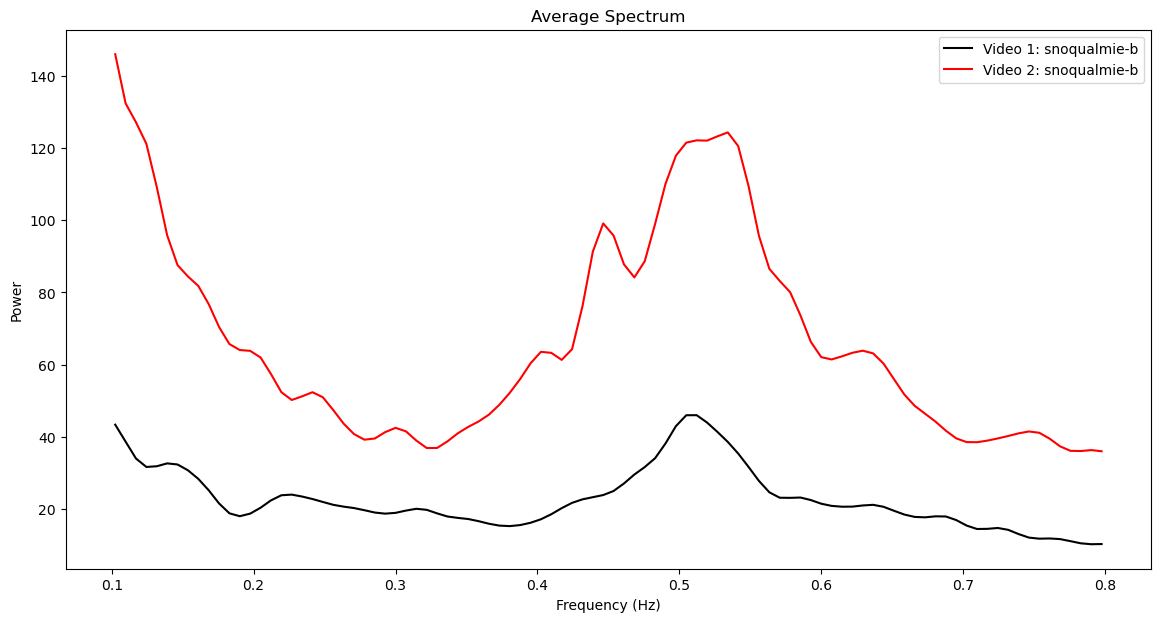

In [21]:
fig, ax = plt.subplots(figsize=(14,7))

ax.plot(freqs, pxx_avg_vvs_v1, color='k', label=f'Video 1: {vid1_name}')
ax.plot(freqs, pxx_avg_vvs_v2, color='red', label=f'Video 2: {vid1_name}')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')

ax.set_title('Average Spectrum')

plt.legend()

### 4.3 Peak frequency histogram comparison

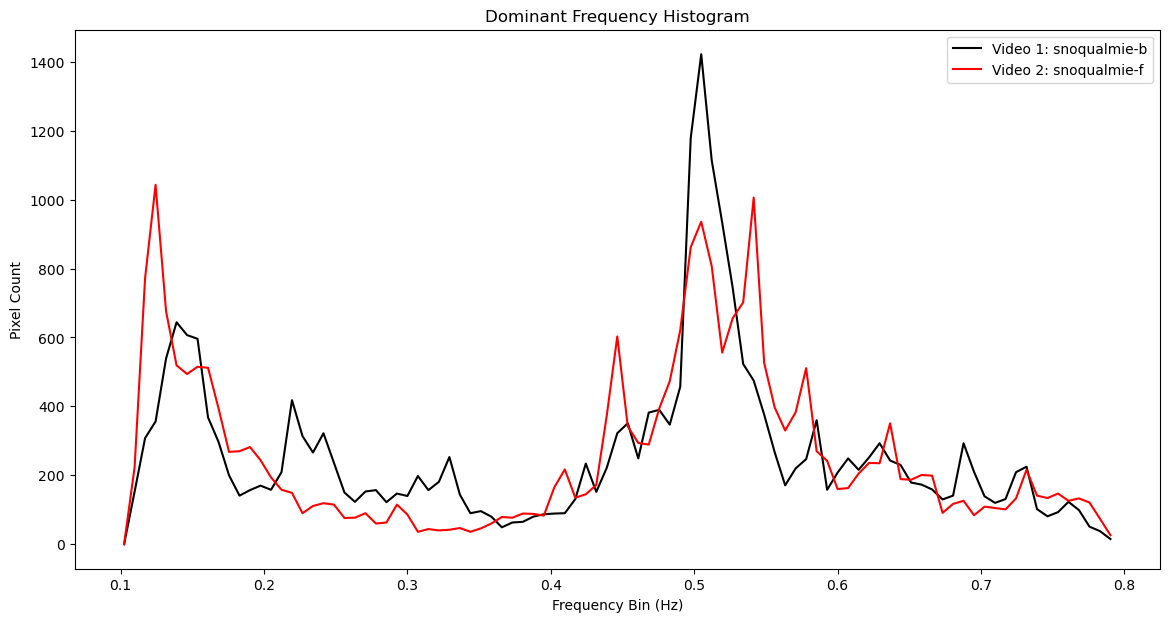

In [22]:
fig, ax = plt.subplots(figsize=figsize)

plotting_utils.plot_freq_histogram(dom_freq_masked_v1.compressed(), freqs, ax=ax, color='k', label_peak=False, density=False, figsize=figsize)
plotting_utils.plot_freq_histogram(dom_freq_masked_v2.compressed(), freqs, ax=ax, color='red', label_peak=False, density=False, figsize=figsize)
plt.legend([f'Video 1: {vid1_name}', f'Video 2: {vid2_name}'])

## 5. Publication-quality plot

**Note: The following plot has been designed specifically for the the 'tree1_whole' ROI and video 1 (snoqualmie-b) and video 2 (snoqualmie-f) representing videos before and after a snow unloading event, respectively. Minor adjustments will likely be needed for other ROIs and videos. In particular, all annotations and the signal label parameters (offset parameters) will need to be adjusted.**

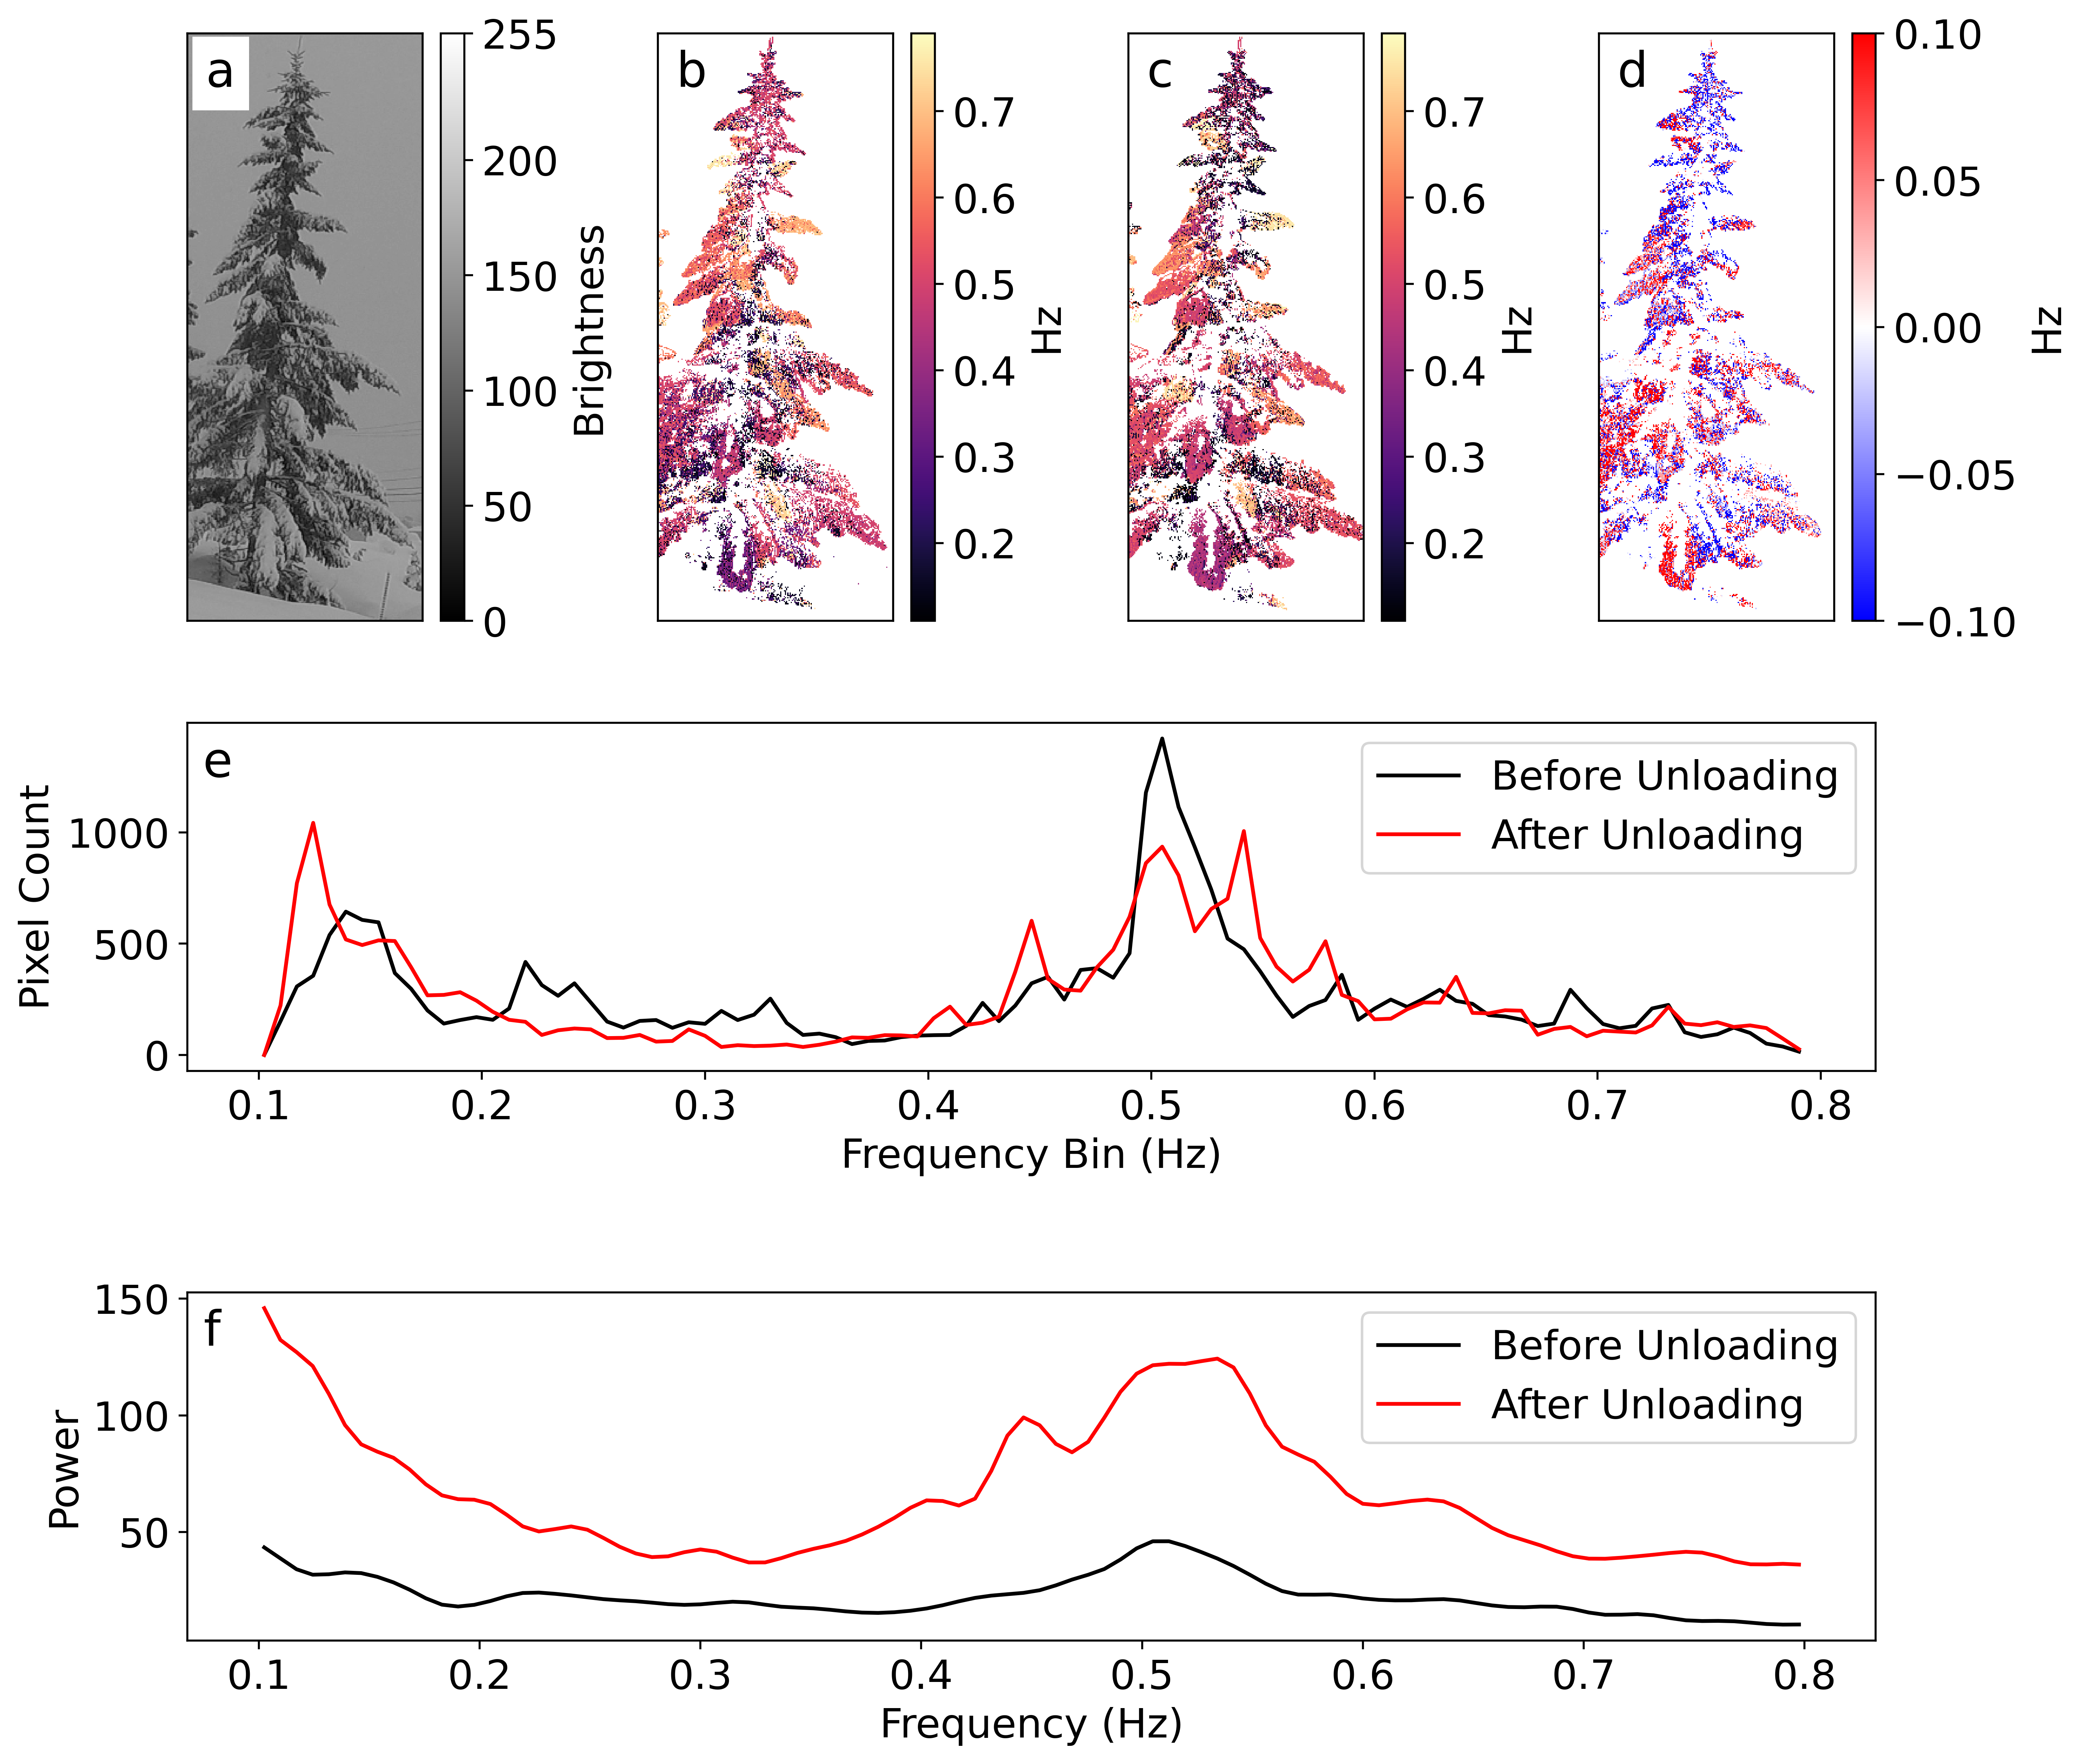

In [23]:
matplotlib.rcParams.update({'font.size': 16})

# define subplot pattern
pattern = '''
ABCD
ABCD
ABCD
ABCD
EEEE
EEEE
....
FFFF
FFFF
'''

# create figure with specified pattern
fig, ax = plt.subplot_mosaic(pattern, figsize=(12,12), dpi=500)

plotting_utils.plot_grayscale_image(vib1[0], 
                                    colorbar=True, 
                                    colorbarlabel='Brightness', 
                                    edgecolor=None, 
                                    ax=ax['A'])
ax['A'].annotate('a', (15,45), c='k', backgroundcolor='w', fontsize='large')

plotting_utils.plot_image(dom_freq_masked_v1, colorbarlabel='Hz', figsize=figsize, ax=ax['B'])
ax['B'].annotate('b', (15,45), c='k', backgroundcolor='w', fontsize='large')

plotting_utils.plot_image(dom_freq_masked_v2, colorbarlabel='Hz', figsize=figsize, ax=ax['C'])
ax['C'].annotate('c', (15,45), c='k', backgroundcolor='w', fontsize='large')

plotting_utils.plot_image(dom_freq_masked_v2 - dom_freq_masked_v1, colorbarlabel='Hz', cmap='bwr', figsize=figsize, ax=ax['D'], low=-0.1, high=0.1)
ax['D'].annotate('d', (15,45), c='k', backgroundcolor='w', fontsize='large')

plotting_utils.plot_freq_histogram(dom_freq_masked_v1.compressed(), freqs, ax=ax['E'], color='k', label_peak=False, density=False, figsize=figsize, title='')
plotting_utils.plot_freq_histogram(dom_freq_masked_v2.compressed(), freqs, ax=ax['E'], color='red', label_peak=False, density=False, figsize=figsize, title='')
ax['E'].legend([f'Before Unloading', f'After Unloading'])
ax['E'].annotate('e', (0.075,1250), c='k', backgroundcolor='w', fontsize='large')

ax['F'].plot(freqs, pxx_avg_vvs_v1, color='k', label='Before Unloading')
ax['F'].plot(freqs, pxx_avg_vvs_v2, color='red', label='After Unloading')
ax['F'].set_xlabel('Frequency (Hz)')
ax['F'].set_ylabel('Power')
ax['F'].legend()
ax['F'].annotate('f', (0.075,130), c='k', backgroundcolor='w', fontsize='large')

plt.subplots_adjust(wspace=0.7)